<a href="https://colab.research.google.com/github/AsinaMilic/image_classification_with_vision_transformers/blob/main/deit3_small_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast

In [3]:
#models = timm.list_models()
#for model in models:
#    print(model)


In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def load_data(directory, input_shape):
    x = []
    y = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                x.append(image)
                y.append(class_name)
    x = np.array(x)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return x, y_encoded, label_encoder.classes_

input_shape = (224, 224, 3)
train_dir = '/content/drive/MyDrive/Chiro10/train_512'
test_dir = '/content/drive/MyDrive/Chiro10/test_512'
val_dir = '/content/drive/MyDrive/Chiro10/val_512'

x_train, y_train, classes = load_data(train_dir, input_shape)
x_test, y_test, _ = load_data(test_dir, input_shape)
x_val, y_val, _ = load_data(val_dir, input_shape)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



train_dataset = CustomDataset(x_train, y_train, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vit_base_patch16_224 64 32 32
model = timm.create_model('deit3_small_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, len(classes))
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))



model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
evaluate_model(model, criterion, test_dataloader)
torch.save(model.state_dict(), '/content/drive/MyDrive/deit3_small_patch16_224.pth')


x_train shape: (923, 224, 224, 3) - y_train shape: (923,)
x_test shape: (554, 224, 224, 3) - y_test shape: (554,)
x_val shape: (369, 224, 224, 3) - y_val shape: (369,)
Epoch 0/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 3.0539 Acc: 0.1322


100%|██████████| 12/12 [00:01<00:00,  7.50it/s]


val Loss: 2.3234 Acc: 0.1924

Epoch 1/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


train Loss: 2.2191 Acc: 0.1993


100%|██████████| 12/12 [00:01<00:00,  7.45it/s]


val Loss: 2.1626 Acc: 0.1734

Epoch 2/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


train Loss: 2.1211 Acc: 0.2232


100%|██████████| 12/12 [00:01<00:00,  7.34it/s]


val Loss: 2.0957 Acc: 0.2764

Epoch 3/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 2.0639 Acc: 0.2503


100%|██████████| 12/12 [00:01<00:00,  7.45it/s]


val Loss: 1.9710 Acc: 0.3360

Epoch 4/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.9411 Acc: 0.3174


100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


val Loss: 1.9281 Acc: 0.2846

Epoch 5/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 1.8192 Acc: 0.3619


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


val Loss: 1.7399 Acc: 0.3604

Epoch 6/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 1.7036 Acc: 0.4052


100%|██████████| 12/12 [00:01<00:00,  6.91it/s]


val Loss: 1.6691 Acc: 0.4499

Epoch 7/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 1.6019 Acc: 0.4594


100%|██████████| 12/12 [00:01<00:00,  6.59it/s]


val Loss: 1.6209 Acc: 0.4282

Epoch 8/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.5846 Acc: 0.4529


100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


val Loss: 1.5349 Acc: 0.4661

Epoch 9/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 1.4958 Acc: 0.5049


100%|██████████| 12/12 [00:01<00:00,  7.26it/s]


val Loss: 1.4956 Acc: 0.4634

Epoch 10/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 1.4196 Acc: 0.5634


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 1.4375 Acc: 0.5447

Epoch 11/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


train Loss: 1.4278 Acc: 0.5385


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


val Loss: 1.4385 Acc: 0.4932

Epoch 12/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.3721 Acc: 0.5590


100%|██████████| 12/12 [00:01<00:00,  7.53it/s]


val Loss: 1.3953 Acc: 0.5312

Epoch 13/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.3424 Acc: 0.5991


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


val Loss: 1.3888 Acc: 0.5203

Epoch 14/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.3289 Acc: 0.6035


100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


val Loss: 1.2851 Acc: 0.6179

Epoch 15/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.2601 Acc: 0.6555


100%|██████████| 12/12 [00:01<00:00,  6.76it/s]


val Loss: 1.4635 Acc: 0.5664

Epoch 16/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.3190 Acc: 0.6046


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


val Loss: 1.3109 Acc: 0.5854

Epoch 17/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.2706 Acc: 0.6349


100%|██████████| 12/12 [00:01<00:00,  7.37it/s]


val Loss: 1.3124 Acc: 0.6016

Epoch 18/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 1.2532 Acc: 0.6587


100%|██████████| 12/12 [00:01<00:00,  7.51it/s]


val Loss: 1.2854 Acc: 0.6206

Epoch 19/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.1843 Acc: 0.6934


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


val Loss: 1.2401 Acc: 0.6640

Epoch 20/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 1.1501 Acc: 0.7205


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 1.2238 Acc: 0.6775

Epoch 21/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 1.1131 Acc: 0.7248


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


val Loss: 1.2022 Acc: 0.6748

Epoch 22/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


train Loss: 1.0953 Acc: 0.7378


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 1.1413 Acc: 0.7317

Epoch 23/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.0680 Acc: 0.7649


100%|██████████| 12/12 [00:01<00:00,  7.42it/s]


val Loss: 1.1750 Acc: 0.6829

Epoch 24/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.0342 Acc: 0.7562


100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


val Loss: 1.1099 Acc: 0.7100

Epoch 25/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 1.0262 Acc: 0.7746


100%|██████████| 12/12 [00:01<00:00,  6.60it/s]


val Loss: 1.3333 Acc: 0.6504

Epoch 26/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 1.1406 Acc: 0.7248


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


val Loss: 1.1310 Acc: 0.7534

Epoch 27/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 1.0688 Acc: 0.7454


100%|██████████| 12/12 [00:01<00:00,  7.50it/s]


val Loss: 1.2016 Acc: 0.6721

Epoch 28/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 1.1316 Acc: 0.7216


100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


val Loss: 1.1624 Acc: 0.7154

Epoch 29/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 1.0446 Acc: 0.7595


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 1.1412 Acc: 0.6938

Epoch 30/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.9824 Acc: 0.7779


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


val Loss: 1.0776 Acc: 0.7344

Epoch 31/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.9495 Acc: 0.8158


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 1.0313 Acc: 0.7588

Epoch 32/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.9584 Acc: 0.7985


100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


val Loss: 1.0199 Acc: 0.7669

Epoch 33/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.9016 Acc: 0.8397


100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


val Loss: 1.0103 Acc: 0.7859

Epoch 34/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.8968 Acc: 0.8234


100%|██████████| 12/12 [00:01<00:00,  6.63it/s]


val Loss: 1.0072 Acc: 0.7588

Epoch 35/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.8887 Acc: 0.8332


100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


val Loss: 0.9662 Acc: 0.7967

Epoch 36/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.8595 Acc: 0.8462


100%|██████████| 12/12 [00:01<00:00,  6.71it/s]


val Loss: 1.0196 Acc: 0.7940

Epoch 37/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.9039 Acc: 0.8202


100%|██████████| 12/12 [00:01<00:00,  6.44it/s]


val Loss: 0.9479 Acc: 0.7886

Epoch 38/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


train Loss: 0.8587 Acc: 0.8505


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 1.0845 Acc: 0.7371

Epoch 39/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.8804 Acc: 0.8310


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


val Loss: 0.9217 Acc: 0.8238

Epoch 40/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.8164 Acc: 0.8667


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 0.9493 Acc: 0.7995

Epoch 41/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.8228 Acc: 0.8667


100%|██████████| 12/12 [00:01<00:00,  7.49it/s]


val Loss: 0.9681 Acc: 0.8022

Epoch 42/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.8052 Acc: 0.8819


100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


val Loss: 1.0095 Acc: 0.7724

Epoch 43/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.8174 Acc: 0.8700


100%|██████████| 12/12 [00:01<00:00,  6.52it/s]


val Loss: 0.9571 Acc: 0.7967

Epoch 44/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.7905 Acc: 0.8938


100%|██████████| 12/12 [00:01<00:00,  6.57it/s]


val Loss: 1.0102 Acc: 0.7995

Epoch 45/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.7940 Acc: 0.8862


100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


val Loss: 0.9255 Acc: 0.8211

Epoch 46/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.7608 Acc: 0.8852


100%|██████████| 12/12 [00:01<00:00,  7.33it/s]


val Loss: 0.8923 Acc: 0.8293

Epoch 47/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.7444 Acc: 0.9101


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 0.8869 Acc: 0.8374

Epoch 48/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.7432 Acc: 0.9057


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 0.8875 Acc: 0.8266

Epoch 49/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.7542 Acc: 0.8949


100%|██████████| 12/12 [00:01<00:00,  7.41it/s]


val Loss: 0.8548 Acc: 0.8428

Epoch 50/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.7355 Acc: 0.9036


100%|██████████| 12/12 [00:01<00:00,  7.34it/s]


val Loss: 0.8752 Acc: 0.8130

Epoch 51/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.7211 Acc: 0.9198


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 0.8337 Acc: 0.8482

Epoch 52/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.7161 Acc: 0.9187


100%|██████████| 12/12 [00:01<00:00,  6.82it/s]


val Loss: 0.8802 Acc: 0.8537

Epoch 53/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6968 Acc: 0.9339


100%|██████████| 12/12 [00:01<00:00,  6.50it/s]


val Loss: 0.8116 Acc: 0.8808

Epoch 54/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6774 Acc: 0.9382


100%|██████████| 12/12 [00:01<00:00,  6.49it/s]


val Loss: 0.8422 Acc: 0.8564

Epoch 55/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6746 Acc: 0.9328


100%|██████████| 12/12 [00:01<00:00,  7.19it/s]


val Loss: 0.8190 Acc: 0.8835

Epoch 56/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6580 Acc: 0.9361


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


val Loss: 0.8044 Acc: 0.8808

Epoch 57/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6636 Acc: 0.9426


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.8082 Acc: 0.8753

Epoch 58/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6721 Acc: 0.9339


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.8249 Acc: 0.8726

Epoch 59/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6796 Acc: 0.9426


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


val Loss: 0.8051 Acc: 0.8943

Epoch 60/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.6892 Acc: 0.9339


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


val Loss: 0.9088 Acc: 0.8103

Epoch 61/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.7031 Acc: 0.9198


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 0.8809 Acc: 0.8320

Epoch 62/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6947 Acc: 0.9177


100%|██████████| 12/12 [00:01<00:00,  6.57it/s]


val Loss: 0.9807 Acc: 0.7859

Epoch 63/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.7188 Acc: 0.9079


100%|██████████| 12/12 [00:01<00:00,  6.61it/s]


val Loss: 0.8481 Acc: 0.8347

Epoch 64/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6854 Acc: 0.9242


100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


val Loss: 0.8247 Acc: 0.8699

Epoch 65/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6667 Acc: 0.9242


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 0.9517 Acc: 0.8238

Epoch 66/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.7463 Acc: 0.9112


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


val Loss: 0.8205 Acc: 0.8699

Epoch 67/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.7129 Acc: 0.9112


100%|██████████| 12/12 [00:01<00:00,  7.41it/s]


val Loss: 0.8185 Acc: 0.8591

Epoch 68/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6705 Acc: 0.9339


100%|██████████| 12/12 [00:01<00:00,  7.45it/s]


val Loss: 0.8581 Acc: 0.8482

Epoch 69/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.6835 Acc: 0.9209


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 0.8600 Acc: 0.8482

Epoch 70/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6622 Acc: 0.9339


100%|██████████| 12/12 [00:01<00:00,  7.45it/s]


val Loss: 0.8453 Acc: 0.8591

Epoch 71/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6602 Acc: 0.9404


100%|██████████| 12/12 [00:01<00:00,  7.37it/s]


val Loss: 0.8721 Acc: 0.8482

Epoch 72/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6642 Acc: 0.9382


100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


val Loss: 0.7744 Acc: 0.8862

Epoch 73/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6186 Acc: 0.9621


100%|██████████| 12/12 [00:01<00:00,  6.58it/s]


val Loss: 0.7504 Acc: 0.8997

Epoch 74/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6059 Acc: 0.9599


100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


val Loss: 0.7924 Acc: 0.8862

Epoch 75/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6197 Acc: 0.9588


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


val Loss: 0.7610 Acc: 0.8862

Epoch 76/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6311 Acc: 0.9534


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


val Loss: 0.7727 Acc: 0.8835

Epoch 77/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6395 Acc: 0.9502


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.7936 Acc: 0.8889

Epoch 78/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6116 Acc: 0.9664


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


val Loss: 0.7687 Acc: 0.8943

Epoch 79/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6949 Acc: 0.9274


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.8629 Acc: 0.8672

Epoch 80/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6730 Acc: 0.9263


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.7874 Acc: 0.8889

Epoch 81/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.6222 Acc: 0.9567


100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


val Loss: 0.8197 Acc: 0.8645

Epoch 82/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6450 Acc: 0.9415


100%|██████████| 12/12 [00:01<00:00,  6.66it/s]


val Loss: 0.7793 Acc: 0.8808

Epoch 83/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6191 Acc: 0.9556


100%|██████████| 12/12 [00:01<00:00,  6.52it/s]


val Loss: 0.7590 Acc: 0.8943

Epoch 84/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5854 Acc: 0.9740


100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


val Loss: 0.7423 Acc: 0.8970

Epoch 85/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.5811 Acc: 0.9740


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


val Loss: 0.7467 Acc: 0.9079

Epoch 86/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


train Loss: 0.5955 Acc: 0.9632


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


val Loss: 0.7406 Acc: 0.9051

Epoch 87/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.6136 Acc: 0.9567


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


val Loss: 0.7823 Acc: 0.8916

Epoch 88/99
----------


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


train Loss: 0.5983 Acc: 0.9653


100%|██████████| 12/12 [00:01<00:00,  7.47it/s]


val Loss: 0.7582 Acc: 0.8862

Epoch 89/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.5791 Acc: 0.9751


100%|██████████| 12/12 [00:01<00:00,  7.40it/s]


val Loss: 0.7337 Acc: 0.9133

Epoch 90/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5827 Acc: 0.9686


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


val Loss: 0.8352 Acc: 0.8618

Epoch 91/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5905 Acc: 0.9642


100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


val Loss: 0.7538 Acc: 0.9051

Epoch 92/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 0.5729 Acc: 0.9794


100%|██████████| 12/12 [00:01<00:00,  6.71it/s]


val Loss: 0.7737 Acc: 0.8889

Epoch 93/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.5688 Acc: 0.9772


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


val Loss: 0.8048 Acc: 0.8808

Epoch 94/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5615 Acc: 0.9762


100%|██████████| 12/12 [00:01<00:00,  7.39it/s]


val Loss: 0.7169 Acc: 0.9187

Epoch 95/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5596 Acc: 0.9848


100%|██████████| 12/12 [00:01<00:00,  7.53it/s]


val Loss: 0.7592 Acc: 0.9024

Epoch 96/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.5491 Acc: 0.9870


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


val Loss: 0.7309 Acc: 0.9133

Epoch 97/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5416 Acc: 0.9892


100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


val Loss: 0.7216 Acc: 0.9214

Epoch 98/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


train Loss: 0.5383 Acc: 0.9881


100%|██████████| 12/12 [00:01<00:00,  7.49it/s]


val Loss: 0.7379 Acc: 0.9051

Epoch 99/99
----------


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train Loss: 0.5387 Acc: 0.9892


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


val Loss: 0.7474 Acc: 0.8997

Training complete in 21m 3s
Best val Acc: 0.921409
test Loss: 0.7167 Acc: 0.9116


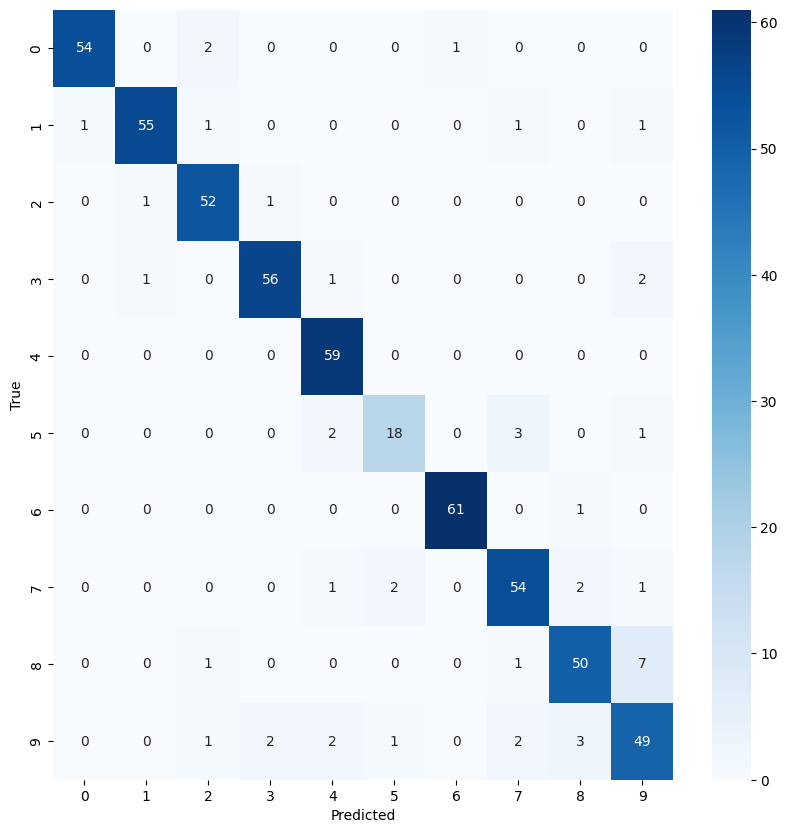

In [9]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_dataloader)